In [1]:
import qutip as qt
from qutip_qip.operations.gates import hadamard_transform as hadamard

import numpy as np
from matplotlib import pyplot as plt

import jax
import jax.numpy as jnp
from diffrax import Dopri5, PIDController

In [2]:
from optimize import optimize_pulses
from time_interval import TimeInterval
from objective import Objective

# Quantum Optimal Control Task

\begin{gather*}
    X(t=0) \underset{H}{\longrightarrow} X_\mathrm{trgt}=X(t=T)
\end{gather*}

\begin{gather}
    \partial_{t} X(t) = - \mathrm i \underbrace{\left( A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k \right)}_{H} X(t)
\end{gather}

Closed system

\begin{array}{c|c|c|c}
 & \text{drift } A        & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}  &  H_d         &  B_k& |\Psi(t, \alpha)>\\
 \text{gate synthesis}       &  H_d         &  B_k & U(t, \alpha)   \\\hline
 \text{state transfer}      &  \hat H_d    &  \hat B_k & \rho(t, \alpha) \\
 \text{gate synthesis}     &  \hat H_d    &  \hat B_k & \hat{U}(t, \alpha)
\end{array}

\begin{gather*}
    g = \frac{1}{\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[X_\mathrm{trgt}^{\dagger} X(T, \alpha) \right]
\end{gather*}

\begin{gather*}
    f_\mathrm{SU} = \mathrm{Re}(g) \text{ and } f_\mathrm{PSU} = |g|
\end{gather*}

Open system

\begin{array}{c|c|c|c}
  & \text{drift } A   & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}     &  \hat H_d +
 \mathrm i \hat{L}    &  \hat B_k& \rho(t, \alpha) \\
 \text{map synthesis}         &   \hat H_d + \mathrm i \hat L    &  \hat B_k& \hat{U}(t, \alpha)\\
\end{array}

\begin{gather*}
    d = \frac{1}{2\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[ (X(T, \alpha) - X_\mathrm{trgt})^\dagger  (X(T, \alpha) - X_\mathrm{trgt})\right]
\end{gather*}

\begin{gather*}
    f_\mathrm{TRCDFF} = \mathrm{Re}(d)
\end{gather*}

---
# GRadient Ascent Pulse Engineering (GRAPE)
---

Slice time interval $T$ in $M$ chunks of size $\Delta t$, with piecewise constant functions $c_j(t_i, \vec \alpha) = \mathrm{const.}$ for $i \in [1, M]$

\begin{gather*}
H(t_i, \alpha) \approx A + \sum_{k=0}^{C-1} \alpha_{i,k} B_k \\

X(t_i, \alpha) = \underbrace{X_i}_{\exp(-\mathrm i H(t_i, \alpha) \Delta t)}
X_{i-1} \dots X_1 X_0
\end{gather*}

update parameters according to $\frac{\partial f^{(r)}(X(t, \alpha))}{\partial \alpha_{i,k}}$

<img src="documentation\DYNAMO.PNG" alt="dynamo" width="600"/>

---
# Chopped RAndom Basis (CRAB)
---

Update initial guess controls $c^{\text{ init}}_k(t, \vec \alpha_k)$ through parameterized update function $g_k(t, \vec \beta_k)$ expanded in some function basis i.e. Fourier:

\begin{align*}
    c^{\text{ update}}_k(t, \vec \alpha_k) &= c^{\text{ init}}_k(t, \vec \alpha_k) \cdot g_k(t, \vec \beta_k) \\ \\
    &= c^{\text{ init}}_k(t, \vec \alpha_k) \left( 1 +
    \sum_{l=1}^{\infty} A_l \sin ( \omega_l t) + B_l \cos ( \omega_l t) \right)
\end{align*}

fix + randomly choose $\omega_l$ and chop to finite basis $l\in[1, L]$

<img src="documentation\CRAB.png" alt="crab" width="600"/>

---
# Gradient Optimization of Analytic conTrols (GOAT)
---

\begin{align}
    \mathrm i\partial_{t} X = & \phantom{xx} H X\\
    \mathrm i\partial_{\alpha}\partial_{t} X = &\partial_{\alpha}  H X
\end{align}

\begin{gather*}
   {\overset{\text{RHS}}{\longrightarrow}} \begin{pmatrix}
        H & 0 \\
        \partial_{{\alpha}}{H}& H \\
    \end{pmatrix}
    \begin{pmatrix}
        X \\
        \partial_{{\alpha}}{X} \\
    \end{pmatrix}
    = \begin{pmatrix}
        H X \\
        (\partial_{{\alpha}}{H}) X + H (\partial_{{\alpha}}{X}) \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        H & 0 & 0 & 0\\
        \partial_{\vec{\alpha}_0}{H}& H & 0 & 0 \\
        \partial_{\vec{\alpha}_1}{H}& 0 & H & 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
     \begin{pmatrix}
        X \\
        \partial_{\vec{\alpha}_0}{X} \\
        \partial_{\vec{\alpha}_1}{X} \\
        \vdots \\
    \end{pmatrix}
    \\ \\ 
\end{gather*}




Algebra ...

\begin{gather*}
   =
    \begin{pmatrix}
        A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)& A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        A & 0 & 0 & 0\\
        0& A & 0 & 0 \\
        0& 0 & A & 0 \\
        0 & 0 & 0 & \ddots \\
    \end{pmatrix}
    +\sum_{k=0}^{C-1}
    \begin{pmatrix}
        c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)&  c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    
    
\end{gather*}

\begin{gather*} =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \begin{pmatrix}
        0 & 0 &  \\
        B_0\, \partial_{\vec{\alpha}_0} c_0(\vec{\alpha}_0, t)& 0 & \\
        B_1\,\partial_{\vec{\alpha}_1} c_1(\vec{\alpha}_1, t)& 0  & \\
        \vdots &  & \ddots \\
    \end{pmatrix}
    \\ \\ =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \sum_{k=0}^{C-1} (\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k}} c_k(\vec{\alpha}_k, t)
\end{gather*}

Details ...
where $\mathbf{1}_{0,k+1}$ is the zero square matrix with only one entry in the first column at row index $1 + (k \cdot M + l)$ set to one, and ($l$ index of) $M$

is the number of varaible parameters for each control amplitude $c_k(\vec{\alpha}_k, t)$, i.e. for a superposition of Gaussian pulses with three variable parameters each $\rightarrow M = 3 \cdot m$:
\begin{gather*}
    c_k(\vec{\alpha}_k, t) = \sum_{l=0}^{M-1} A_{k,l} \exp\left({\frac{-(t-\tau_{k,l})^2}{\sigma_{k,l}^2}}\right)
\end{gather*}

Expressing the Hamiltonian in this form makes it comfortable to implement it using QuTiP
\begin{gather*}
    \underbrace{(\mathbf{I} \otimes A)}_{\mathrm{QobjEvo(}\tilde{H}_d,f(x)=1)}
     + \sum_{k=0}^{C-1}\underbrace{(\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,c_k(\vec{\alpha}_k, t))}
     + \sum_{k=0}^{C-1} \sum_{l=0}^{M-1} \underbrace{(\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,\partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t))}
\end{gather*}

Complexity ...

We have now $1 + C + C \cdot M = O(C \cdot M)$ summands, i.e. the term grows linear with the number of parameters $N_{\mathrm{para}} = C \cdot M$

The size of the matrix however grows with $O(N_{\mathrm{para}} \cdot \mathrm{dim}(A))$

---
# Example: Hadamard Gate (two level system)
---

\begin{gather*}
    X(t=0) = \mathbf{I} \longrightarrow X(T) = \mathrm{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{gather*}

In [3]:
initial = qt.qeye(2)
target  = hadamard()

initial = qt.sprepost(initial, initial.dag())
target  = qt.sprepost(target , target.dag() )

objective = Objective(initial, ... , target)

\begin{gather}
    \partial_{t} X(t) =-\frac{i}{\hbar}[H(\vec{\alpha}, t), X(t)]+ \frac{1}{2} \left[2 C X(t) C^\dagger - X(t) C^\dagger C - C^\dagger C X(t)\right] \\
\end{gather}

\begin{gather*}
    H(\vec{\alpha}, t) = \underbrace{
            \frac{1}{2} \left(\omega \sigma_z +  \Delta \sigma_x\right)
        }_{H_d} 
    + H_c(\vec{\alpha}, t) \text{ and }C = \sqrt \gamma a
\end{gather*}

Time independent drift Hamiltonian

In [4]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

# energy splitting, tunneling, amplitude damping
ω, Δ, γ = 0.1, 1.0, 0.1

Hd = 1/2 * (ω * σz + Δ * σx)

H_d =  qt.liouvillian(H=Hd, c_ops=[np.sqrt(γ) * qt.sigmam()])

In [5]:
π = np.pi
num_ts = 100
interval = TimeInterval(evo_time= 2*π, num_tslots=num_ts)

In [6]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

init_x = np.ones(num_ts)
init_y = np.ones(num_ts)
init_z = np.ones(num_ts)

H = [ H_d,
     [H_c[0], init_x],
     [H_c[1], init_y],
     [H_c[2], init_z]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.01s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.02s. Est. time left: 00:00:00:00
80.8%. Run time:   0.02s. Est. time left: 00:00:00:00
90.9%. Run time:   0.02s. Est. time left: 00:00:00:00
100.0%. Run time:   0.03s. Est. time left: 00:00:00:00
Total run time:   0.03s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

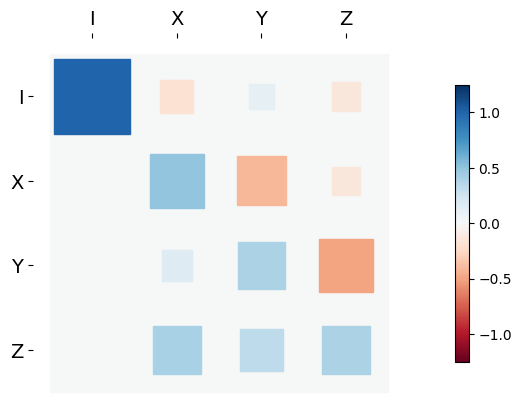

In [7]:
init_evo = qt.mesolve(H, initial, interval.tlist)

qt.hinton(init_evo.final_state)

# QuTiP GRAPE

In [8]:
res_grape = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess":  init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess":  init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess":  init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "GRAPE",
        "fid_err_targ": 0.01,
    }
)

In [9]:
res_grape

Control Optimization Result
       --------------------------
       - Started at 2023-11-15 16:32:30
       - Number of objectives: 1
       - Final fidelity error: 0.0439377751196086
       - Final parameters: [[ 0.99991545  0.99991321  0.9995385   0.99992033  0.99810283  0.99969499
  0.97012454  0.94278158  0.9064599   0.87240861  0.90137676  0.99617005
  0.76288822  0.84542857  0.91178092  0.76295077  0.9776711   0.94562056
  0.99907398  0.9988139   0.99998925  0.99999976  0.99999207  0.99999377
  0.99999518  0.99999595  0.99999697  0.99999733  0.99999521  0.99999212
  0.99998972  0.99998826  0.99998772  0.99998808  0.99998942  0.99999072
  0.99671053  0.98711879  0.98202548  0.97698635  0.98020077  0.99007851
  0.99995988  0.80627242  0.65200952  0.99933544  1.          1.
  1.          0.99996215  0.99979398  0.99942085  0.98775828  0.98611038
  0.99110989  1.          1.          1.          1.          1.
  1.          1.          0.99987335  0.99910338  0.99173364  0.98693635


(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

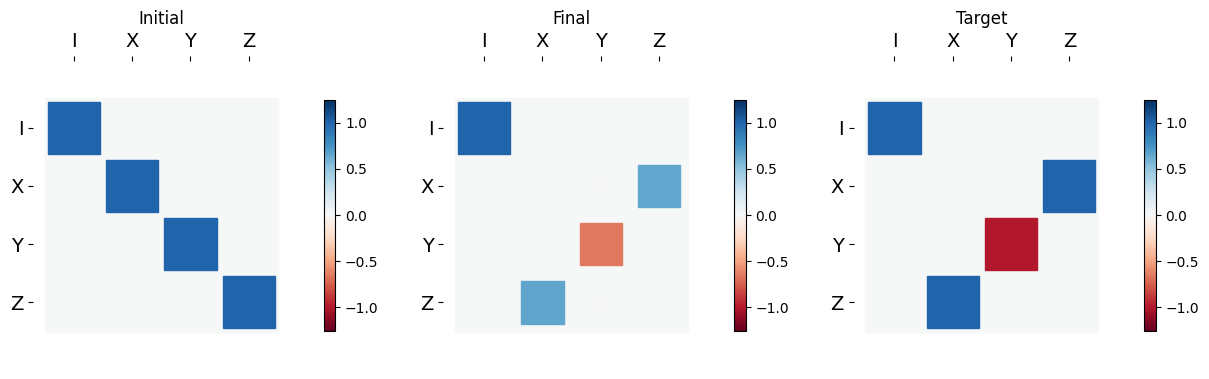

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_grape.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

# QuTiP CRAB

In [11]:
res_crab = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess":  init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess":  init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess":  init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "CRAB", # new
        "fid_err_targ": 0.01,
    }
)

In [12]:
res_crab

Control Optimization Result
       --------------------------
       - Started at 2023-11-15 16:32:37
       - Number of objectives: 1
       - Final fidelity error: 0.04655870762734006
       - Final parameters: [[ 9.87360475e-01  9.91155510e-01  9.93573085e-01  9.95104170e-01
  9.96057353e-01  9.96619486e-01  9.96896302e-01  9.96936244e-01
  9.96740614e-01  9.96260877e-01  9.95380492e-01  9.93873101e-01
  9.91319912e-01  9.86954377e-01  9.79380469e-01  9.66088702e-01
  9.42705973e-01  9.02067983e-01  8.33711812e-01  7.25375551e-01
  5.68636943e-01  3.67941685e-01  1.45210594e-01 -6.84566416e-02
 -2.48321770e-01 -3.84090980e-01 -4.76878914e-01 -5.32365325e-01
 -5.55873487e-01 -5.50143149e-01 -5.14700264e-01 -4.46077231e-01
 -3.39031199e-01 -1.89626003e-01 -6.88030806e-04  2.12732698e-01
  4.24244804e-01  6.06878444e-01  7.45701938e-01  8.40899458e-01
  9.01600208e-01  9.38626135e-01  9.60728312e-01  9.73847044e-01
  9.81656195e-01  9.86315538e-01  9.89057985e-01  9.90568138e-01
  9.91

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

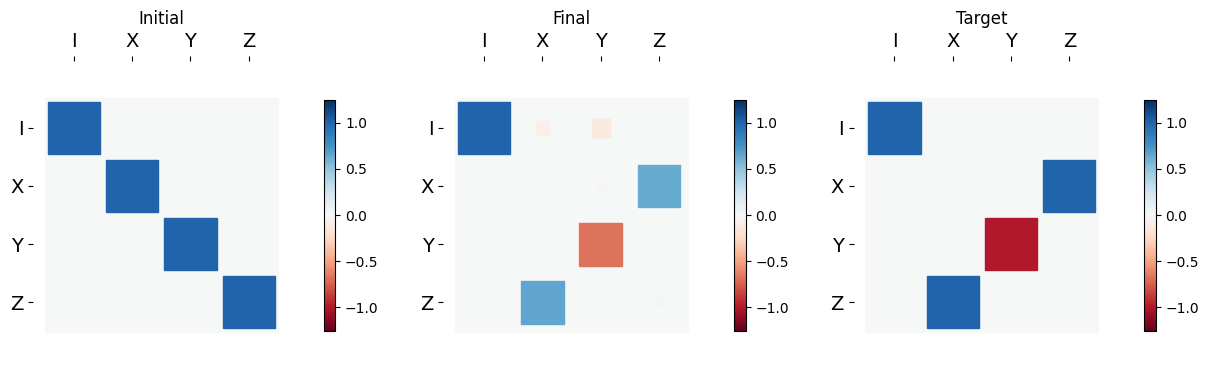

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_crab.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

In [14]:
def plot_result(res, title, y_labels=["$\sigma_x$", "$\sigma_y$", "$\sigma_z$"]):
    fig, ax = plt.subplots(len(res.optimized_controls), 1, figsize=(15, 12), sharex=True)
    ax[0].set_title(title, fontsize=20)

    for i in range(len(res.optimized_controls)):
        ax[i].xaxis.set_label_text('Time')
        ax[i].yaxis.set_label_text('Control ' + y_labels[i])
        ax[i].plot(res.time_interval.tlist, res.guess_controls[i], label='Guess')
        ax[i].plot(res.time_interval.tlist, res.optimized_controls[i], label='Optimized')
        ax[i].legend()

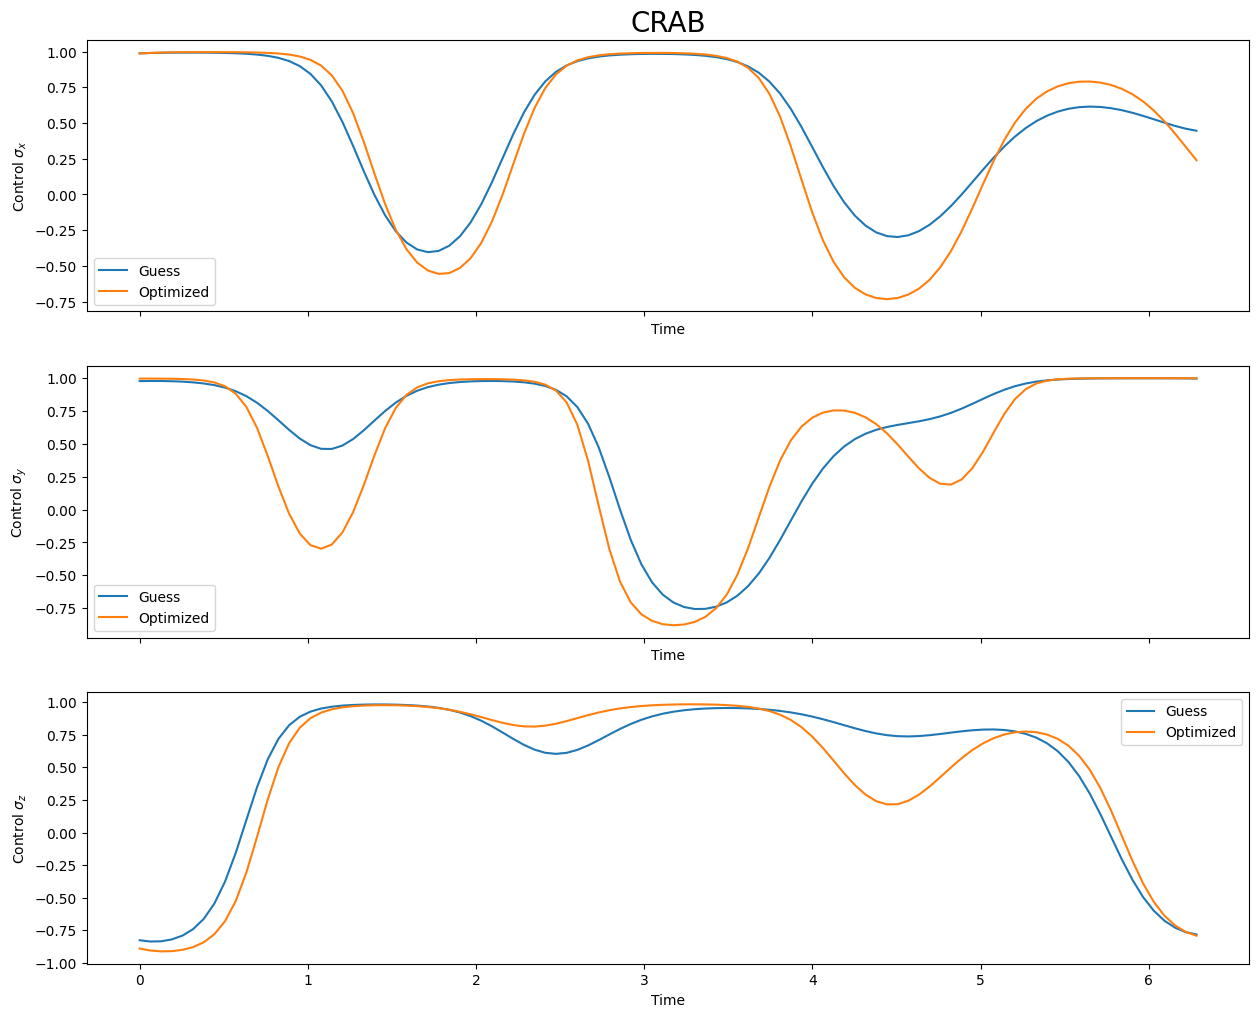

In [15]:
plot_result(res_crab, "CRAB")

# QuTiP GOAT

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [16]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])

def grad_sin(t, α, idx):
    if idx==0: return np.sin(α[1] * t + α[2])
    if idx==1: return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx==2: return α[0] * np.cos(α[1] * t + α[2])
    if idx==3: return α[0] * np.cos(α[1] * t + α[2]) * α[1] # w.r.t. time

In [17]:
sin_x = lambda t, p: sin(t, p)
sin_y = lambda t, q: sin(t, q)
sin_z = lambda t, r: sin(t, r)

In [18]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

H = [ H_d,
     [H_c[0], sin_x, {"grad": grad_sin}],
     [H_c[1], sin_y, {"grad": grad_sin}],
     [H_c[2], sin_z, {"grad": grad_sin}]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.4%. Run time:   0.01s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.01s. Est. time left: 00:00:00:00
80.8%. Run time:   0.02s. Est. time left: 00:00:00:00
90.9%. Run time:   0.02s. Est. time left: 00:00:00:00
100.0%. Run time:   0.02s. Est. time left: 00:00:00:00
Total run time:   0.02s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

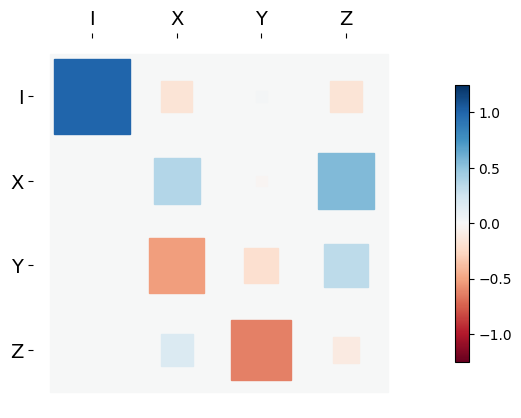

In [19]:
p_init = [1, 1, 0] # amplitude, frequency, phase
q_init = [1, 1, 0] # q[0] * sin(q[1] * t + q[2])
r_init = [1, 1, 0]

init_evo = qt.mesolve(H, initial, interval.tlist,
                      options={'normalize_output': False},
                      args={"p": p_init, "q": q_init, "r": r_init})

qt.hinton(init_evo.final_state)

In [20]:
res_goat = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess":  p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "q": {
            "guess":  q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "r": {
            "guess":  r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "GOAT", # new
        "fid_err_targ": 0.01,
        "max_iter": 0, # new
    },
    optimizer_kwargs = {
        "seed": 1, # new
    }
)

ValueError: The number of bounds is not compatible with the length of `x0`.

In [ ]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-15 11:47:55
- Number of objectives: 1
- Final fidelity error: 0.04403656960277009
- Final parameters: [[1.0, 0.6462771162438175, 2.1425609700529074], [0.9996894160117288, 0.990898249375864, 0.004499661412899851], [0.8444724950457054, 2.379880939421669e-09, 0.2993300539999815]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-15 11:47:58 (3.4204s)

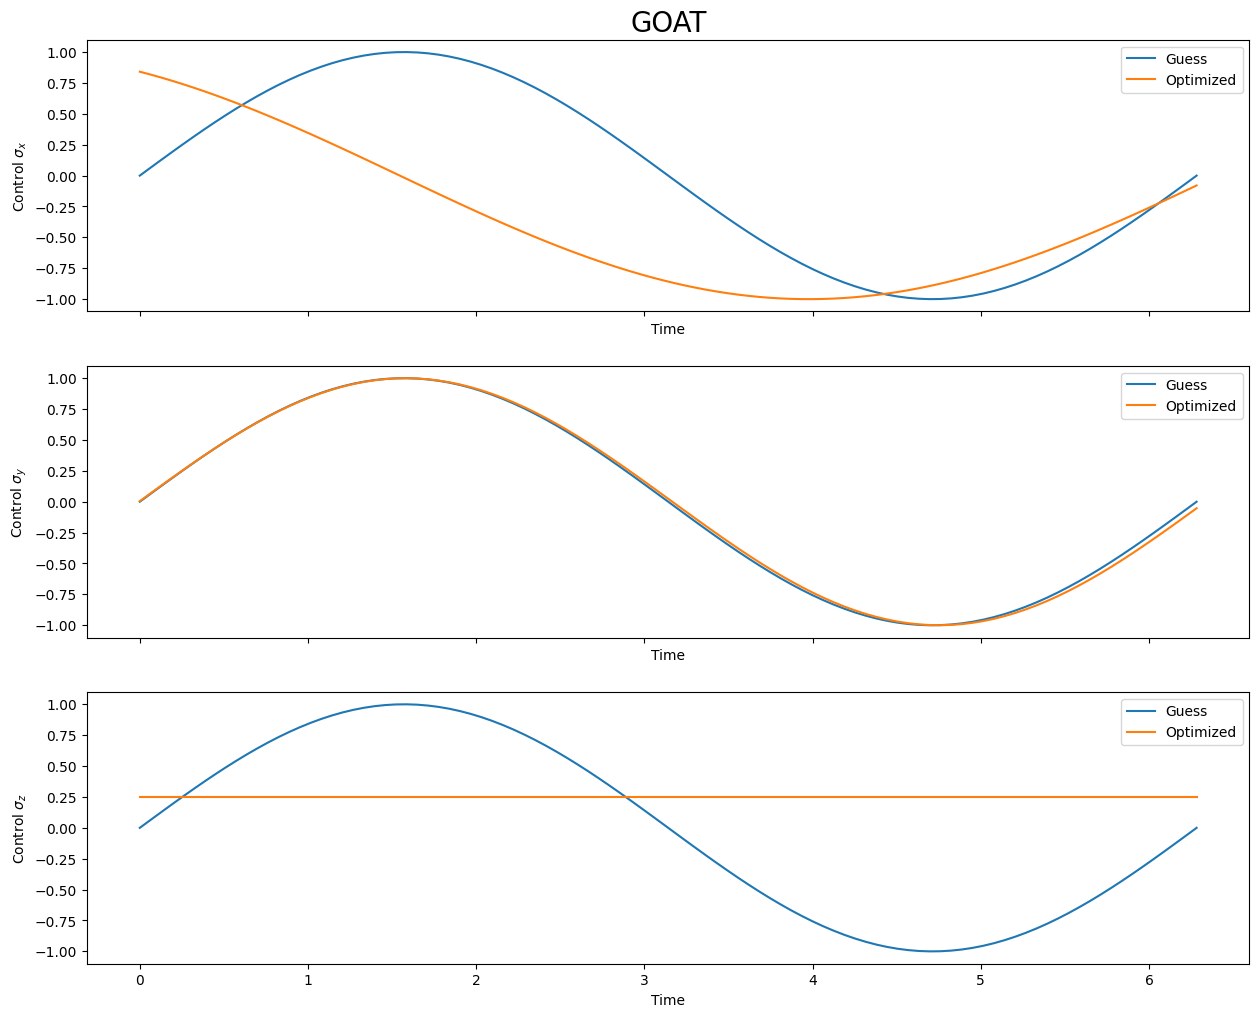

In [ ]:
plot_result(res_goat, "GOAT")

# QuTiP JAX

In [20]:
from diffrax import Dopri5, Dopri8, Tsit5, PIDController

In [21]:
def sin_jax(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

In [22]:
@jax.jit
def sin_x_jax(t, p, **kwargs):
    return sin_jax(t, p)

@jax.jit
def sin_y_jax(t, q, **kwargs):
    return sin_jax(t, q)

@jax.jit
def sin_z_jax(t, r, **kwargs):
    return sin_jax(t, r)

In [23]:
Hc  = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

H_jax = [ H_d,
     [H_c[0], sin_x_jax],
     [H_c[1], sin_y_jax],
     [H_c[2], sin_z_jax]]

In [45]:
res_joat = optimize_pulses(
    objectives = [Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess":  p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "q": {
            "guess":  q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "r": {
            "guess":  r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        }
    },
    time_interval = interval,
    algorithm_kwargs = {
        "alg": "JOAT", # new
        "fid_err_targ": 0.01,
        "max_iter": 0,
    },
    optimizer_kwargs = {
        "seed": 1,
    }
)


KeyboardInterrupt



In [ ]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-11-15 11:47:59
- Number of objectives: 1
- Final fidelity error: 0.04455113743096623
- Final parameters: [[0.999553068793097, 0.9677108939313139, 1.3896276385936615], [0.7368374722530612, 0.7802926694405331, 1.5571836032831659], [0.3879646737896883, 0.0, 1.7601127919800026]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-15 11:48:12 (13.0941s)

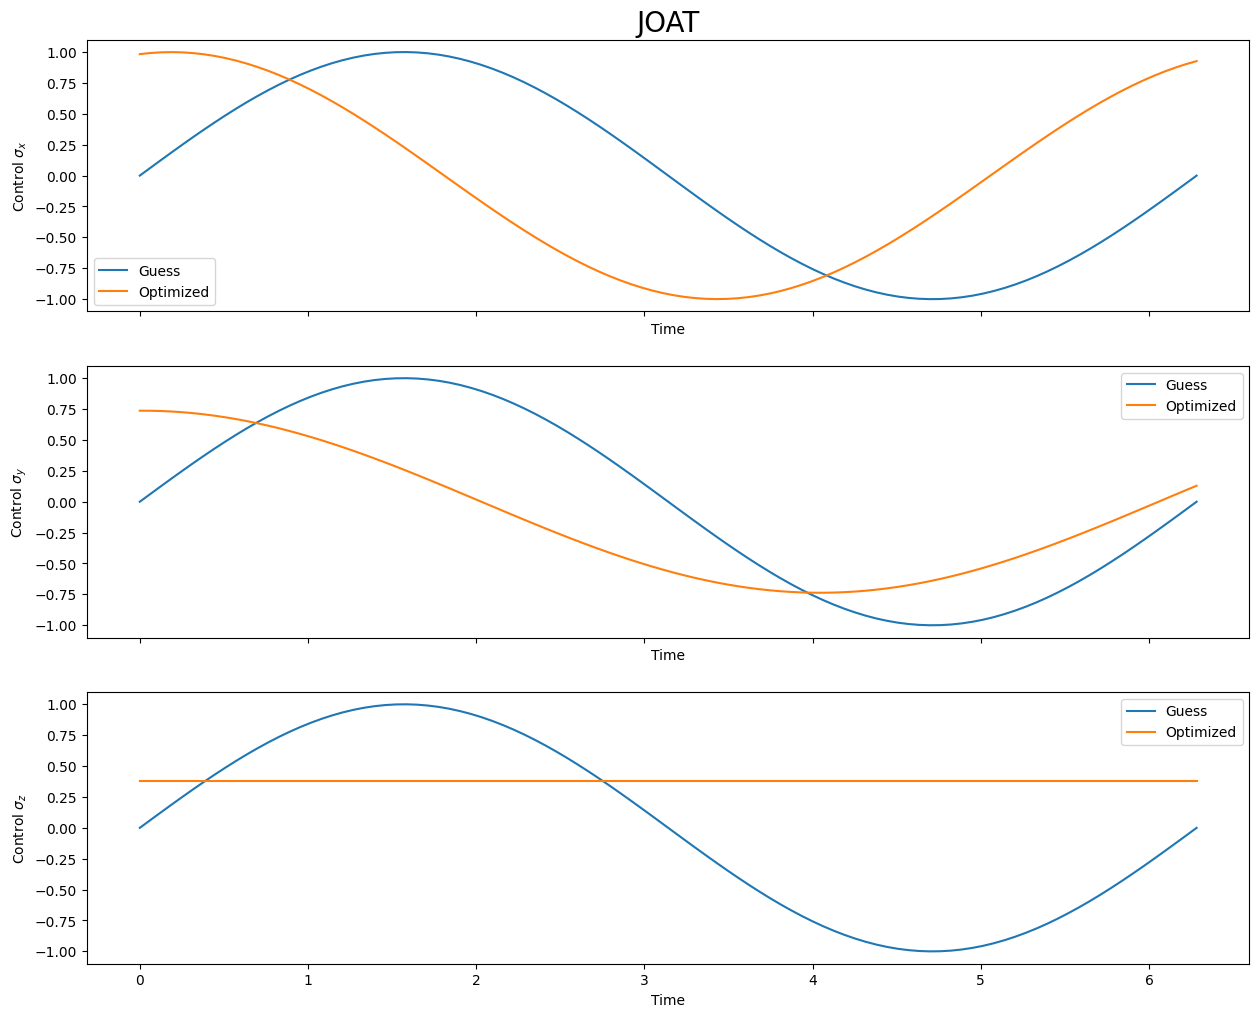

In [ ]:
plot_result(res_joat, "JOAT")

# Time Optimization

In [25]:
res_goat = optimize_pulses(
    objectives = [Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess":  p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "q": {
            "guess":  q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "r": {
            "guess":  r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        }
    },
    time_interval = interval,
    time_options = {  # new
        "guess": interval.evo_time, 
        "bounds": (0, 2*interval.evo_time),
    },
    algorithm_kwargs = {
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "max_iter": 10,
    },
    optimizer_kwargs = {
        "seed": 1,
    },
    integrator_kwargs = {  # new
        "atol": 1e-5, 
        "rtol": 1e-5,
        "method": "dop853",
    },
)

KeyboardInterrupt: 

In [196]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-11-15 11:50:29
- Number of objectives: 1
- Final fidelity error: 0.010254543771147342
- Final parameters: [[1.0, 1.0, 2.5508435030978482], [0.9826477850870246, 0.9182759805487342, 0.22187956660600033], [-1.0, 0.8674049452186274, 1.764430657210104], [2.3706331792915507]]
- Number of iterations: 10
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-15 11:50:36 (7.088s)

In [26]:
res_joat = optimize_pulses(
    objectives = [Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess":  p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "q": {
            "guess":  q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        },
        "r": {
            "guess":  r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2*π)],
        }
    },
    time_interval = interval,
    time_options = {
        "guess": interval.evo_time, 
        "bounds": (0, 2*interval.evo_time),
    },
    algorithm_kwargs = {
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "max_iter": 10,
    },
    optimizer_kwargs = {
        "seed": 1,
    },
    integrator_kwargs = {
        "stepsize_controller": PIDController(
            atol = 1e-5,
            rtol = 1e-5,
        ),
        "solver": Dopri8(),
    },
)

KeyboardInterrupt: 

In [198]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-11-15 11:50:40
- Number of objectives: 1
- Final fidelity error: 0.04414198710251781
- Final parameters: [[-0.7984719737334832, 0.5772198775548996, 0.24336243029795507], [-0.5184630789340052, 0.21371151463343602, 1.1811433464022638], [0.14287889818779675, 0.09291754988292711, 0.6743285915205396]]
- Number of iterations: 10
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-11-15 11:51:36 (56.1117s)

# Scale-up

In [ ]:
N = 3 # number of qubits

initial = qt.tensor([qt.qeye(2)] * N)
target  = qt.tensor([hadamard()] * N)

initial = qt.sprepost(initial, initial.dag())
target  = qt.sprepost(target , target.dag() )

In [ ]:
print(qt.destroy(2))

In [ ]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

ω, Δ, γ, π = 0.1, 1.0, 0.1, np.pi

Hd = 1/2 * (ω * σz + Δ * σx)

H_d =  qt.liouvillian(H=qt.tensor([Hd] * N),
                      c_ops=[np.sqrt(γ) * qt.create(2**N)])

In [ ]:
interval = TimeInterval(evo_time= 2*π)

# GOAT

In [ ]:
n_sup = 3
n_var = 3
n_tot = n_sup * n_var

In [ ]:
from cy_pulse import SinPulse

sin = SinPulse(n_sup, n_var)

In [ ]:
Hc = []
id = [qt.qeye(2) for _ in range(N)]

for i in range(N): # 3N controls
       sx, sy, sz = id.copy(), id.copy(), id.copy()
       sx[i], sy[i], sz[i] = σx, σy, σz
       Hc.append(qt.tensor(sx))
       Hc.append(qt.tensor(sy))
       Hc.append(qt.tensor(sz))

H_c = [qt.liouvillian(H) for H in Hc]

H = [H_d] + [[hc, sin.gen_pulse, {"grad": sin.gen_grad}] for hc in H_c]

In [ ]:
p_init = np.ones(n_tot)

# JOAT

In [ ]:
from diffrax import Dopri5, Dopri8, Tsit5, PIDController

In [ ]:
def sin_(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

pulse_vmap = jax.vmap(sin_, in_axes=(None, 0))

@jax.jit
def sin_jax(t, α):    
    alpha = jnp.reshape(α, (n_sup, n_var))
    return jnp.sum(pulse_vmap(t, alpha), axis=0)

In [ ]:
H_jax = [H_d] + [[hc, sin_jax] for hc in H_c]

# Time Optimization

In [ ]:
p_options = {}
for p in range(len(H_c)-1):
    p_options[p] = {
                "guess":  0.1 * np.ones(n_tot),
                "bounds": [(-π, π) for _ in range(n_tot)],
            }

In [ ]:
res_joat = optimize_pulses(
    objectives = [Objective(initial, H_jax, target)],
    pulse_options=p_options,
    time_interval = interval,
    time_options = {
        "guess": 2*interval.evo_time, 
        "bounds": (0, 2*interval.evo_time),
    },
    algorithm_kwargs = {
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "max_iter": 0,
        "disp": True,
    },
    optimizer_kwargs = {
        "seed": 1,
    },
    integrator_kwargs = {
        "stepsize_controller": PIDController(
            atol = 1e-8,
            rtol = 1e-8,
        ),
        "solver": Dopri8(),
    },
)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function infid at /home/patrick/Code/qoc/joat.py:124 for jit. This concrete value was not available in Python because it depends on the value of the argument params.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError